# Brownian Motion Simulation

The posed problem is this. Given two initially stationary particles in a box of a certain size undergoing Brownian motion, calculate the average time that the particles collide in two situation: 
- Both particles are free to move
- Only one particle is free to move
    
I think the second case is a limiting condition of the first, in the situation when the mass of the second particle is much larger than the first. I'm not sure how to deal with the box boundary conditions. I could treat the box as "infinite" and have periodic conditions, or have collisions off of the box be reflective. The latter is probably the most physical. For convenience, I'll model this in 2D first.

The physics of the situation will be based on propagating Newton's third law in time, and having time-varying kicks coming from the particles inducing the Brownian motion at each time-step.

So starting with $\vec{F}(t) = m \vec{a}$, we have the dynamical system
$$
\begin{eqnarray}
\dot{\vec{v}} &=& \frac{\vec{F}(t)}{m} \\
\dot{\vec{r}} &=& \vec{v} \\
\end{eqnarray}
$$
This is done for every particle in the box, where I integrate for an unknown amount of time until I detect a collision.

The question is how to characterize the force vector. The straight-forward way is to actually simulate the motion of particles inducing the Brownian motion. This will be paramterized by the temperature of the box. That sounds very inefficient. I would like to find an analytic expression for the distribution of the force that the "gas" exerts on the particles and sample that for each time step. There might be a semi-analytical way to do this problem using the Langevin equation, but I don't know stochastic calculus. For now, let's try the stupid way.

## The stupid way

We'll be simulating a large number of small particles with a velocity distribution given by (say) the Maxwell-Boltzmann distribution and initial velocities are random. During each collision, we have to use the conservation of momentum and energy equations to keep the temperature of the box the same.

To do these simulations relatively quickly, I'll be using a 2D game engine based on Chipmunk.

In [1]:
%pylab inline

rcParams['figure.figsize'] = (12, 10)
import scipy.stats as stats
import numpy as np
import pymunk
import pymunk.matplotlib_util

BOUNDARY_MASK = 1<<1
PARTICLE_MASK = 1<<2

class Context(object):
    '''Global world state.
    '''
    def __init__(self, width, height):
        self.space = pymunk.Space()
        self.width = width
        self.height = height
        
        lw = 0.1
        bb = []
        bb.append(pymunk.Segment(self.space.static_body, (0, 0), (0, height), lw))
        bb.append(pymunk.Segment(self.space.static_body, (0, height), (width, height), lw))
        bb.append(pymunk.Segment(self.space.static_body, (width, height), (width, 0), lw))
        bb.append(pymunk.Segment(self.space.static_body, (width, 0), (0, 0), lw))
        
        for bs in bb:
            bs.elasticity = 0.9999999
            bs.filter = pymunk.ShapeFilter(categories=BOUNDARY_MASK)
            self.space.add(bs)
        
        self.boltzmann_particles = []
             
    def render_mpl(self, fig= None, ax=None):
        fig = fig if fig is not None else figure()
        ax = axes(xlim=(-self.width*0.2, 1.2*self.width), ylim=(-self.height*0.2, 1.2*self.height)) if ax is None else ax
        ax.set_aspect("equal")
        o = pymunk.matplotlib_util.DrawOptions(ax)
        o.shape_static_color = (149/255, 165/255, 166/255, 100/255)
        
        self.space.debug_draw(o)
        return fig, ax
    
    def populate_particles(self, mass, radius, avg_distance, n_candidates=30):
        # make temporary bounding box to make sure that we generate particles within it; it gets removed later
        box_body = pymunk.Body(0, 0, pymunk.Body.STATIC)
        bounding_box = pymunk.Poly(box_body, [(0, 0), (0, self.height), (self.width, self.height), (self.width, 0)])
        bounding_box.filter = pymunk.ShapeFilter(categories=BOUNDARY_MASK)
        self.space.add(box_body, bounding_box)
        
        # place initial sample
        x = stats.uniform.rvs(loc=radius, scale=self.width)
        y = stats.uniform.rvs(loc=radius, scale=self.height)
        
        p = Particle(mass, radius, (x, y))
        p.add_to(self)
        self.boltzmann_particles.append(p)

        active_list = [p]
        iteration = 0
        
        while len(active_list) > 0: # keep working until active list is empty
            idx = stats.randint.rvs(0, len(active_list)) # choose random index in active list
            active_point = active_list[idx]
            
            # generate n_candidates uniformally within an annulus of avg_distance to 2*avg_distance
            radii = stats.uniform.rvs(loc=avg_distance, scale=avg_distance, size=n_candidates)
            angles = stats.uniform.rvs(loc=0, scale=2*np.pi, size=n_candidates)
            for i, (r,a) in enumerate(zip(radii, angles)):
                x = r*cos(a)
                y = r*sin(a)
                
                pos = (active_point.body.position[0] + x, active_point.body.position[1] + y) 
                q = self.space.point_query_nearest(pos, avg_distance, 
                                                   pymunk.ShapeFilter(mask=PARTICLE_MASK))
                if (not q) or (q.distance > avg_distance):
                    # Check that we're within the bounding box
                    pq = self.space.point_query_nearest(pos, avg_distance, pymunk.ShapeFilter(mask=BOUNDARY_MASK))
                    
                    if pq and (pq.distance < -radius):
                        candidate_point = Particle(mass, radius, pos)
                        candidate_point.add_to(self)
                        self.boltzmann_particles.append(candidate_point)
                        active_list.append(candidate_point)
                        break
                if i == n_candidates - 1:
                    active_list.pop(idx)
            #print('Length of active list: ', len(active_list))
            #print('Finished iteration ', iteration)
            iteration += 1
        self.space.remove(box_body)
        self.space.remove(bounding_box)
        

    def assign_velocities(self, T = 100):
        speeds = stats.maxwell.rvs(loc=T, size=len(self.boltzmann_particles))
        angles = stats.uniform.rvs(loc=0, scale=2*np.pi, size=len(self.boltzmann_particles))
        xs, ys = speeds*np.cos(angles), speeds*np.sin(angles)
        
        for p, vx, vy in zip(self.boltzmann_particles, xs, ys):
            p.body.velocity = (vx, vy)
            
    def step(self, dt=1e-2):
        self.space.step(dt)
            
class Particle(object):
    '''A particle that can collide with other particles or with the box
    '''
    nparticles = 0
    
    def __init__(self, mass, radius, position):
        self.id = Particle.nparticles
        Particle.nparticles += 1
        #print('Created particle ', self.id)
        self.mass = mass
        self.radius = radius
        
        moment = pymunk.moment_for_circle(mass, 0, radius, (0, 0))
        self.body = pymunk.Body(mass, moment)
        self.body.position = pymunk.Vec2d(position)
        self.shape = pymunk.Circle(self.body, radius)
        self.shape.elasticity = 0.9999999
        self.shape.filter = pymunk.ShapeFilter(categories=PARTICLE_MASK)
    
    def add_to(self, ctx):
        ctx.space.add(self.body, self.shape)

Populating the interactive namespace from numpy and matplotlib
Loading chipmunk for Linux (64bit) [/home/aloukian/anaconda3/envs/py35/lib/python3.5/site-packages/pymunk/libchipmunk64.so]


<cdata 'cpSpaceDebugColor &' 0x7fce75487f8c>


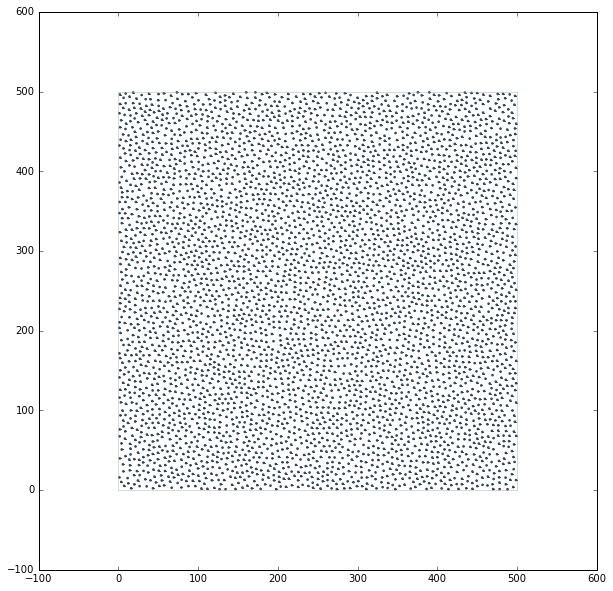

In [3]:
ctx = Context(500, 500)
ctx.populate_particles(10, 1, 5, n_candidates=30)
ctx.render_mpl()
savefig('poisson_packed.png')

Ok, now I can "randomly" pack the volume with tiny particles and presumably evolve them in time.

<cdata 'cpSpaceDebugColor &' 0x7fce75abf26c>


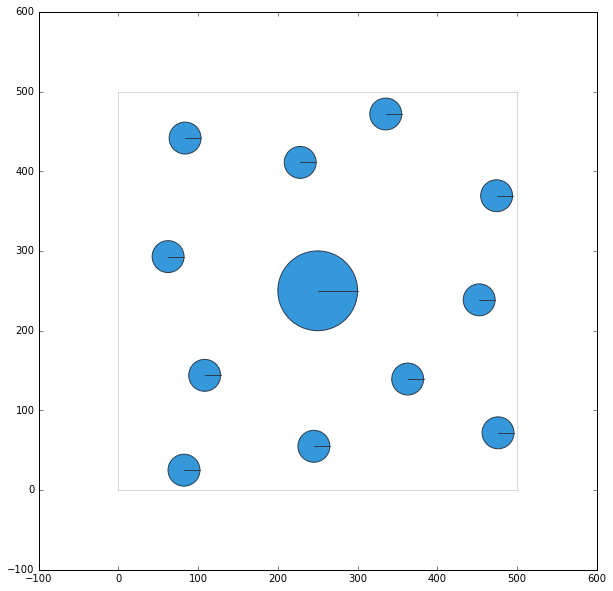

In [4]:
ctx = Context(500, 500)
p = Particle(10, 50, (250, 250))
p.add_to(ctx)
ctx.populate_particles(10, 20, 100, n_candidates=30)
ctx.assign_velocities(T=100)
ctx.render_mpl();

In [3]:
import pymunk.pyglet_util
import pyglet

In [4]:
ctx = Context(500, 500)
p = Particle(10, 50, (100, 250))
p.add_to(ctx)
p = Particle(1e9, 50, (400, 250))
p.add_to(ctx)
ctx.populate_particles(1, 1, 10, n_candidates=30)
ctx.assign_velocities(T=100)

window = pyglet.window.Window(500, 500, vsync=False)
draw_options = pymunk.pyglet_util.DrawOptions()

pyglet.clock.set_fps_limit(60)

def step(dt):
    ctx.space.step(1/60)
    
pyglet.clock.schedule_interval(step, 0.02)

@window.event
def on_draw():
    pyglet.gl.glClearColor(255,255,255,255)
    window.clear()
    ctx.space.debug_draw(draw_options)

pyglet.app.run()

## Getting trajectories

Right, now the idea is that after each time-step I can calculate the distance between centers of the two large balls stop integration when they get within some small value of each other. Cutting down on the rendering of this will speed up the runtime significantly.

In [5]:
from collections import deque
import sys

def simulate_trajectory(seed, scale_mass = 10, scale_size = 10, 
                        stationary = False, reltol=1e-4, dt=1e-2, fake=False, quiet=True, pickleable=True):
    ''' simulate a single trajectory
    id: just a tag for each trajectory
    scale_mass: how much more massive the large particles are compared to the Brownian particles
    scale_size: the ratio of the radius of the large particles to the small ones
    stationary: whether one of the large particles is stationary
    '''
    np.random.seed(seed)
    mass_one = 100
    mass_two = 1e9 if stationary else mass_one
    mass_small = mass_one/scale_mass
    
    radius_small = 5
    radius_large = radius_small*scale_size
    
    box_size = 500, 500
    
    ctx = Context(*box_size)
    
    ctx.distance = deque()
    
    ctx.one = Particle(mass_one, radius_large, (100, 250))
    ctx.one.add_to(ctx)
    
    ctx.two = Particle(mass_two, radius_large, (400, 250))
    ctx.two.add_to(ctx)
    
    ctx.populate_particles(mass_small, radius_small, radius_small*2, n_candidates=30)
    ctx.assign_velocities(T=100)
    
    distance = lambda ctx: np.linalg.norm(ctx.one.body.position - ctx.two.body.position, ord=2)
    if not quiet:
        print('Using {:d} brownian particles'.format(len(ctx.boltzmann_particles)))
        
    if fake:
        ctx.render_mpl()
        return ctx
    

    n = 0
    while distance(ctx) > (2*radius_large*(1 + reltol)):
        ctx.distance.append(distance(ctx))
        ctx.step(dt)
        n += 1
        
        if (n % 100 == 0) and (not quiet):
            print('Iteration count: {:d}'.format(n))
    
    if pickleable:
        return seed, n, np.array(ctx.distance)
    else:
        return ctx

In [6]:
ctx = simulate_trajectory(0, dt=0.01, quiet=False, pickleable=False)

Using 695 brownian particles
Iteration count: 100
Iteration count: 200
Iteration count: 300
Iteration count: 400
Iteration count: 500
Iteration count: 600
Iteration count: 700
Iteration count: 800
Iteration count: 900
Iteration count: 1000
Iteration count: 1100
Iteration count: 1200
Iteration count: 1300
Iteration count: 1400
Iteration count: 1500
Iteration count: 1600
Iteration count: 1700
Iteration count: 1800
Iteration count: 1900
Iteration count: 2000
Iteration count: 2100
Iteration count: 2200
Iteration count: 2300
Iteration count: 2400
Iteration count: 2500
Iteration count: 2600
Iteration count: 2700
Iteration count: 2800
Iteration count: 2900
Iteration count: 3000
Iteration count: 3100
Iteration count: 3200
Iteration count: 3300
Iteration count: 3400
Iteration count: 3500
Iteration count: 3600
Iteration count: 3700
Iteration count: 3800
Iteration count: 3900
Iteration count: 4000
Iteration count: 4100
Iteration count: 4200
Iteration count: 4300
Iteration count: 4400
Iteration co

<cdata 'cpSpaceDebugColor &' 0x7fce75abfd0c>


(<matplotlib.figure.Figure at 0x7fce752e4f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fce6cf64320>)

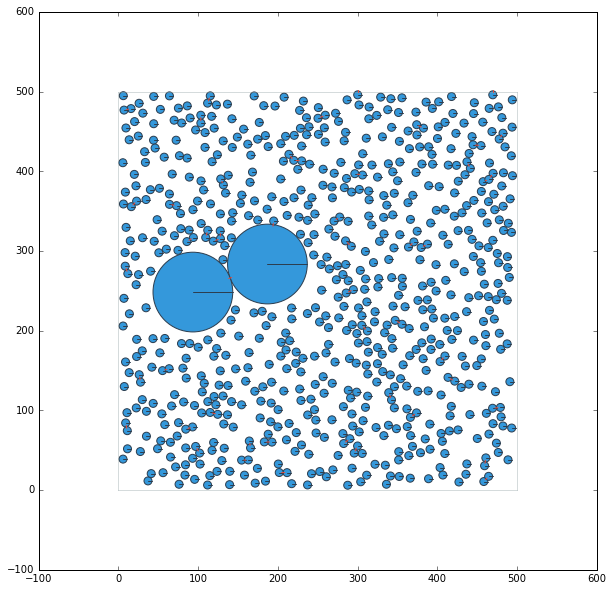

In [7]:
ctx.render_mpl()

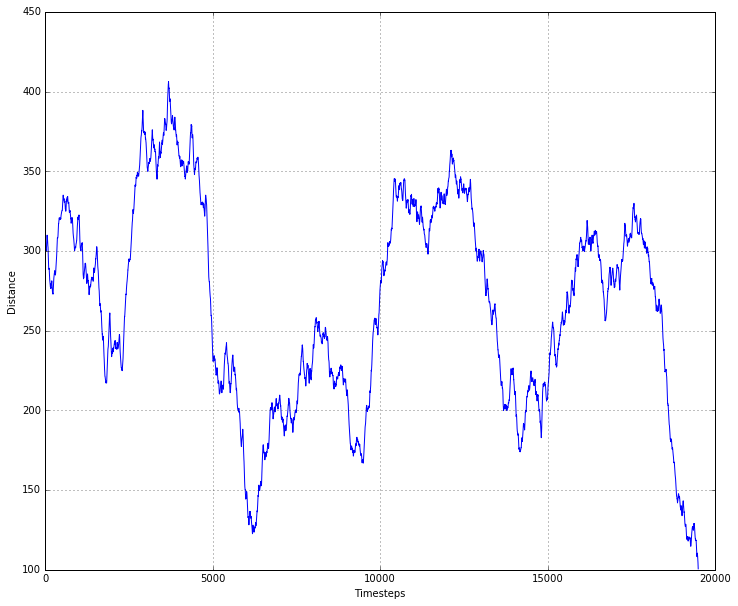

In [8]:
plot(ctx.distance)
grid()
xlabel('Timesteps')
ylabel('Distance')

In [9]:
len(ctx.distance)

19502

Ok, so I can simulate one trajectory; I need multiple. Multiprocess this stuff. I split out the code into a separate python file.

Ran into an annoying problem. Apparently when you use multiprocessing, the random number generator seed also gets inherited by each process. This means that all the random data that is generated is actually identical, despite each process running the right functions. Live and learn. 

To check, run the code below without the ```np.random.seed()``` line.

In [9]:
#sim = partial(simulate_trajectory, dt=0.05, quiet=True, pickleable=True)
import time
import scipy.stats as stats
import multiprocessing

def gen_randoms(id):
    np.random.seed()
    rnd = stats.uniform.rvs(size=2)
    time.sleep(1)
    return id, rnd

with multiprocessing.Pool(5) as p:
    result = p.map(gen_randoms, range(10))

## Multiprocessing the trajectories

In [ ]:
import multiprocessing
from functools import partial
from ipywidgets import FloatProgress
from IPython.display import display
import time
from collections import deque
from chest import Chest

n_trajectories = 1000

#sim = partial(simulate_trajectory, dt=0.05, quiet=True)
async_results = deque()
data = Chest(path='brownian-nonstationary.chest', available_memory=2*1e9)

f = FloatProgress(value=0, min=0, max=n_trajectories, description='Running trajectories:', sync=True)
display(f)
    
p = multiprocessing.Pool()

for seed in np.random.randint(low=0, high=1<<31, size=n_trajectories):
    res = p.apply_async(simulate_trajectory, args=(seed,), kwds={'dt': 0.01, 'quiet': True, 'scale_mass': 1e2})
    async_results.append(res)
    
while len(async_results) > 0:
    n_complete = n_trajectories - len(async_results)
    f.value = n_complete
    
    g = async_results.pop()
    if g.ready():
        seed, n, d = g.get()
        data[seed] = (n, d)
    else:
        async_results.appendleft(g)
        
    time.sleep(0.1)

p.close()
data.flush() # close pool and write to disk

In [89]:
n_trajectories = 1000

#sim = partial(simulate_trajectory, dt=0.05, quiet=True)
async_results = deque()
data = Chest(path='brownian-stationary.chest', available_memory=2*1e9)

f = FloatProgress(value=0, min=0, max=n_trajectories, description='Running trajectories:', sync=True)
display(f)
    
p = multiprocessing.Pool()

for seed in np.random.randint(low=0, high=1<<31, size=n_trajectories):
    res = p.apply_async(simulate_trajectory, args=(seed,), kwds={'dt': 0.01, 'quiet': True, 
                                                                 'stationary': True, 'scale_mass': 1e2})
    async_results.append(res)
    
while len(async_results) > 0:
    n_complete = n_trajectories - len(async_results)
    f.value = n_complete
    
    g = async_results.pop()
    if g.ready():
        seed, n, d = g.get()
        data[seed] = (n, d)
    else:
        async_results.appendleft(g)
        
    time.sleep(0.1)

p.close()
data.flush() # close pool and write to disk

(array([ 561.,  291.,   94.,   26.,   18.,    7.,    2.,    0.,    0.,    1.]),
 array([   1282. ,   23523.2,   45764.4,   68005.6,   90246.8,  112488. ,
         134729.2,  156970.4,  179211.6,  201452.8,  223694. ]),
 <a list of 10 Patch objects>)

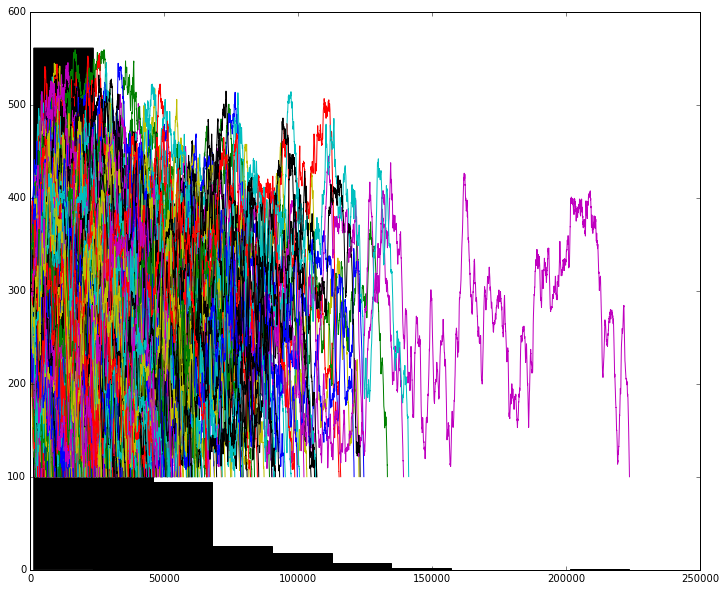

In [85]:
ns = []
for k, (n, d) in data2.items():
    ns.append(n)
    plot(d, label='{:d}'.format(seed))

hist(ns)

(array([  98.,  134.,  127.,  106.,   96.,   89.,   54.,   54.,   49.,
          45.,   24.,   23.,   17.,   17.,   13.,    6.,    5.,    6.,
           6.,    3.,    6.,    3.,    4.,    5.,    0.,    2.,    1.,
           3.,    0.,    1.,    0.,    2.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([   1282.  ,    5730.24,   10178.48,   14626.72,   19074.96,
          23523.2 ,   27971.44,   32419.68,   36867.92,   41316.16,
          45764.4 ,   50212.64,   54660.88,   59109.12,   63557.36,
          68005.6 ,   72453.84,   76902.08,   81350.32,   85798.56,
          90246.8 ,   94695.04,   99143.28,  103591.52,  108039.76,
         112488.  ,  116936.24,  121384.48,  125832.72,  130280.96,
         134729.2 ,  139177.44,  143625.68,  148073.92,  152522.16,
         156970.4 ,  161418.64,  165866.88,  170315.12,  174763.36,
         179211.6 ,  183659.84,  188108.08,  192556.32, 

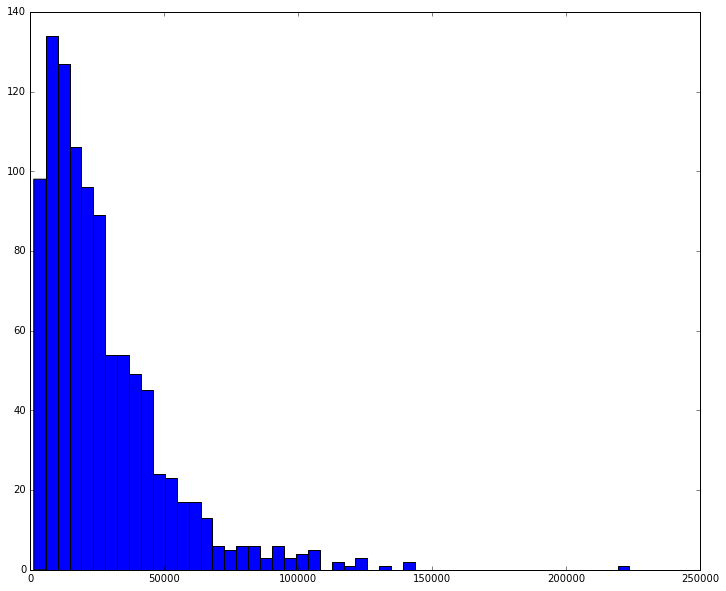

In [86]:
hist(ns, 50)